In [1]:
%matplotlib inline

In [2]:
import glob, os, sys, json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns


In [3]:
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('matplotlib version: ', mpl.__version__)
print('seaborn version: ', sns.__version__)


numpy version:  1.21.2
pandas version:  1.3.2
matplotlib version:  3.5.0
seaborn version:  0.11.0


# Beta Ranking Analyses 

This notebook includes the code used to generate color-coded rankings of beta weights from Figure 5. 



In [4]:
"""
Define support functions to build a DataFrame of image labels
"""
def cap_vals(row, value, cap):
    if row[value] > cap:
        return cap
    else:
        return row[value]
    
    
def label_cft(row):
    grp_val = row['cfpt']
    if grp_val == 3:
        return '1. human face'
    elif grp_val == 2:
        return '2. mammal face'
    elif grp_val == 1:
        return '3. other face'
    elif grp_val == 0:
        return '4. no face'

    
def label_clt(row):
    grp_val = row['clpt']
    if grp_val >= 3:
        return '1. human'
    elif grp_val == 2:
        return '2. mammal'
    elif grp_val == 1:
        return '3. other living thing'
    elif grp_val == 0:
        return '4. no living thing'

    
def label_cbt(row):
    grp_val = row['cbpt']
    if grp_val >= 3:
        return '1. human body'
    elif grp_val == 2:
        return '2. mammal body'
    elif grp_val == 1:
        return '3. other living body'
    elif grp_val == 0:
        return '4. no living body'

    
def label_bkpt(row):
    grp_val = row['bkpt']
    if grp_val >= 3:
        return '1. scene'
    elif grp_val == 2:
        return '2. rich background'
    elif grp_val == 1:
        return '3. minimum background'
    elif grp_val == 0:
        return '4. no background'
    
    
def label_rf(row):
    grp_val = row['chfrf']
    if grp_val == 2:
        return '1. natural human face'
    elif grp_val == 1:
        return '2. artificial human face'
    elif grp_val == 0:
        return '3. no human face'
    

def generate_data(
    beta_idx: np.array,
    img_idx: np.array,
    ranked_betas: np.array,
    img_details: dict,
) -> pd.DataFrame:
    """
    Builds DataFrame of betas, image labels and annotations to plot ranked betas
    """
    df_2plot = pd.DataFrame(ranked_betas, columns=['betas'])
    #pic_names = [img_idx[x] for x in beta_idx]

    """
    Face stuff
    """
    is_face = np.array([img_details[img_idx[x]]['manual_face'] for x in beta_idx])
    is_human_face = np.array([img_details[img_idx[x]]['manual_human_face'] for x in beta_idx])
    is_nh_mammal_face = np.array([img_details[img_idx[x]]['manual_nh_mammal_face'] for x in beta_idx])
    is_central_face = np.array([img_details[img_idx[x]]['manual_central_face'] for x in beta_idx])
    is_artificial_face = np.array([img_details[img_idx[x]]['manual_artificial_face'] for x in beta_idx])

    df_2plot['is_face'] = is_face.astype(bool)
    df_2plot['is_central_face'] = is_central_face.astype(bool)
    df_2plot['is_noncentral_face'] = (is_face*(is_central_face==0)).astype(bool)
    df_2plot['is_human_face'] = is_human_face.astype(bool)
    df_2plot['is_central_human_face'] = (is_human_face*is_central_face).astype(bool)
    df_2plot['is_noncentral_human_face'] = (is_human_face*(is_central_face==0)).astype(bool)
    df_2plot['is_central_mammal_face'] = ((is_human_face*is_central_face)+(is_nh_mammal_face*is_central_face)).astype(bool)

    # levels: central face that is human (3), nh_mammal (2), or something else (1)
    df_2plot['cfpt'] = (is_central_face + (2*(is_central_face*is_human_face)) + (is_central_face*is_nh_mammal_face)).astype(int)
    df_2plot['cfpt'] = df_2plot.apply(lambda row: cap_vals(row, 'cfpt', 3), axis=1)
    df_2plot['central_face_per_type'] = df_2plot.apply(lambda row: label_cft(row), axis=1)

    # levels: central human face that is natural (2) or artificial (1)
    df_2plot['chfrf'] = (((is_human_face*is_central_face)*2) - (is_human_face*is_central_face*is_artificial_face)).astype(int)
    df_2plot['chfrf'] = df_2plot.apply(lambda row: cap_vals(row, 'chfrf', 3), axis=1)
    df_2plot['central_human_face_realORfake'] = df_2plot.apply(lambda row: label_rf(row), axis=1)

    
    """
    Body stuff
    """
    has_body = np.array([img_details[img_idx[x]]['manual_body'] for x in beta_idx])
    has_human_body = np.array([img_details[img_idx[x]]['manual_human_body'] for x in beta_idx])
    has_nh_mammal_body = np.array([img_details[img_idx[x]]['manual_nh_mammal_body'] for x in beta_idx])
    has_central_body = np.array([img_details[img_idx[x]]['manual_central_body'] for x in beta_idx])
    has_artificial_body = np.array([img_details[img_idx[x]]['manual_artificial_body'] for x in beta_idx])

    df_2plot['has_body'] = has_body.astype(bool)
    df_2plot['has_central_body'] = has_central_body.astype(bool)
    df_2plot['has_human_body'] = has_human_body.astype(bool)
    df_2plot['has_central_human_body'] = (has_human_body*has_central_body).astype(bool)

    df_2plot['has_living'] = (has_body + is_face).astype(bool)
    df_2plot['has_central_living'] = ((has_body*has_central_body) + (is_face*is_central_face)).astype(bool)

    # levels: central living (body or face): human (3), nh_mammal (2) or something else (1)
    centr_human = ((has_human_body*has_central_body) + (is_human_face*is_central_face)).astype(bool)
    centr_mammal = ((has_nh_mammal_body*has_central_body) + (is_nh_mammal_face*is_central_face)).astype(bool)
    df_2plot['clpt'] = (df_2plot['has_central_living'].to_numpy() + (2*centr_human) + centr_mammal).astype(int)
    df_2plot['clpt'] = df_2plot.apply(lambda row: cap_vals(row, 'clpt', 3), axis=1)
    df_2plot['central_living_per_type'] = df_2plot.apply(lambda row: label_clt(row), axis=1)

    # levels: central body: human (3), nh_mammal (2) or something else (1)
    df_2plot['cbpt'] = (has_central_body + (2*(has_central_body*has_human_body)) + (has_central_body*has_nh_mammal_body)).astype(int)
    df_2plot['cbpt'] = df_2plot.apply(lambda row: cap_vals(row, 'cbpt', 3), axis=1)
    df_2plot['central_body_per_type'] = df_2plot.apply(lambda row: label_cbt(row), axis=1)

    
    """
    Scene stuff
    """    
    is_lone_object = np.array([img_details[img_idx[x]]['manual_lone_object'] for x in beta_idx])
    is_scene = np.array([img_details[img_idx[x]]['manual_scene'] for x in beta_idx])
    had_bcground = np.array([img_details[img_idx[x]]['manual_rich_background'] for x in beta_idx])

    df_2plot['is_scene'] = is_scene.astype(bool)
    df_2plot['has_bckground'] = had_bcground.astype(bool)
    df_2plot['background_or_scene'] = (had_bcground + is_scene).astype(bool)

    # levels: is lone object (0), object (1), bckground (2) or scene (3)
    df_2plot['bkpt'] = (np.ones(df_2plot.shape[0]) + had_bcground + 2*(is_scene) - is_lone_object).astype(int)
    df_2plot['bkpt'] = df_2plot.apply(lambda row: cap_vals(row, 'bkpt', 3), axis=1)
    df_2plot['background_per_type'] = df_2plot.apply(lambda row: label_bkpt(row), axis=1)

    df_2plot['rank'] = np.array(df_2plot.index + 1).astype(int)

    return df_2plot


In [5]:
"""
Define paths and parameters
"""
# Set paths
data_file_path = Path("../../THINGS/things.glmsingle").resolve()
fig_save_path = Path("../figures").resolve()

# Define color options
hue_options = {
    'annotation-face': ('central_face_per_type', {'1. human face':'xkcd:burnt red', '2. mammal face':'xkcd:bright orange', '3. other face':'xkcd:apple green', '4. no face':"xkcd:baby blue"}),
    'annotation-body': ('central_body_per_type', {'1. human body':'xkcd:burnt red', '2. mammal body':'xkcd:bright orange', '3. other living body':'xkcd:apple green', '4. no living body':'xkcd:baby blue'}),
    'annotation-scene': ('background_per_type', {'1. scene':'xkcd:burnt red', '2. rich background':'xkcd:bright orange', '3. minimal background':'xkcd:apple green', '4. no background':"xkcd:baby blue"}),
}

# Load image labels and annotations
with open(f"{data_file_path}/task-things_imgAnnotations.json", "r") as f:
    image_details = json.load(f)


## Code to generate beta rankings from Figure 5

These plots feature image-wise (averaged over 3 repetitions) or trial-wise normalized (z-scored) betas, ranked from largest (left) to smallest (right), and color-coded to reflect image content annotations (e.g., the presence or absence of faces, scenary or body parts).

**In Figure 5 from the datapaper**, rankings are shown for image-wise betas from the one voxel with the highest noise ceiling within an ROI mask derived from the fLoc task (ROIs = fusiform face area (FFA), parahippocampal place area (PPA) and extrastriate body area (EBA)). 

To re-create these plots, set ``top_voxel = True`` and ``per_image = True`` in the options below.

The current notebook can also plot **beta rankings from single trials** (set ``per_image = False``). 

Both trial-wise and image-wise beta rankings can be based on betas from the **one voxel** with the highest noise ceiling (``top_voxel = True``) within an ROI, or from **betas averaged across the 50 voxels** with the highest noise ceilings within an ROI (``top_voxel = False``). 


In [6]:
"""
If True, ranks betas from the ROI's single voxel with the highest noise ceiling.

If False, averages betas across the 50 ROI voxels with the highest noise ceilings,
and then rank these mean betas. 

Set to True to re-create Figure 5 from the datapaper.
"""
top_voxel = True


"""
If True, ranks betas averaged per image (over 3 repetitions) within each voxel.
Excludes images with any blank answer and images with fewer than 3 repetitions.

If False, ranks trial-wise betas (exclude trials with blank answers).

Set to True to re-create Figure 5 from the datapaper.
"""
per_image = True


# set to True to export .png file
save_fig = False

# Specify ROI between: fusiform face area (FFA), extrastriate body area (EBA), and parahipp. place area (PPA)
roi = 'face_roi-FFA'  # 'face_roi-FFA', 'body_roi-EBA', 'scene_roi-PPA'


# Select ranked betas' color-coded annotation among the 3 choices below:
hue_choice = 'annotation-face'  # 'annotation-face', 'annotation-body', 'annotation-scene'


1. human face, color:'xkcd:burnt red'
2. mammal face, color:'xkcd:bright orange'
3. other face, color:'xkcd:apple green'
4. no face, color:'xkcd:baby blue'
sub-01


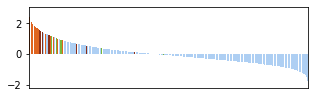

sub-02


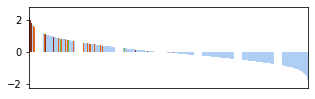

sub-03


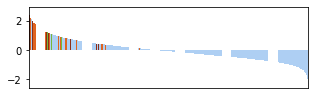

sub-06


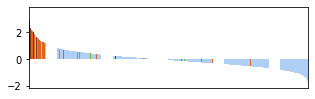

In [7]:
"""
Generate the beta ranking plots

Warnings:
- each plot can take several minutes to generate due to the large number of betas 
  (especially if per_image = False)
- high image resolution is needed for patterns to appear clearly.
- Saved .png images look much sharper and fuller than the ones displayed in this notebook
  (notebook patterns can appear incomplete/patchy)
"""

SMALL_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title


desc = "perImage" if per_image else "perTrial"
hue, palette = hue_options[hue_choice]

for k, v in palette.items():
    print(f"{k}, color:'{v}'")
    
for s in ['01', '02', '03', '06']:
    betas = np.load(
        glob.glob(
            f"{data_file_path}/sub-{s}/descriptive/sub-{s}_task-things_space-T1w_contrast-{roi}_*"
            f"_stats-betas_desc-{desc}_statseries.npy"
        )[0], allow_pickle=True)

    imgIdx = np.load(
        f"{data_file_path}/sub-{s}/descriptive/sub-{s}_task-things_desc-{desc}_labels.npy",
        allow_pickle=True)

    noiseCeil = np.load(
        glob.glob(
            f"{data_file_path}/sub-{s}/descriptive/sub-{s}_task-things_space-T1w_contrast-{roi}_*"
            f"_stats-noiseCeilings_desc-{desc}_statseries.npy"
        )[0], allow_pickle=True)


    if top_voxel:
        """
        Rank betas from single voxel with highest noise ceiling within ROI mask
        """    
        # get top voxel's betas
        top_idx = np.argmax(noiseCeil)
        select_betas = betas[:, top_idx] 
        nvox = "nvox-1"

    else:
        """
        Average betas from all (n=50) ROI voxels and rank mean betas
        """    
        select_betas = np.mean(betas, axis=1)
        nvox = f"nvox-{betas.shape[1]}"


    # sort selected betas from larger to smaller beta
    betas_idx = np.argsort(select_betas, axis=0)[::-1]  
    ranked_betas = select_betas[betas_idx]

    # get corresponding betas' image annotations
    df_annotations = generate_data(betas_idx, imgIdx, ranked_betas, image_details)

    plt.figure(figsize=(5, 1.5))
        
    sns.barplot(
        data=df_annotations,
        x='rank',
        y='betas',
        hue=hue,
        palette=palette,
        dodge=False,
    )

    plt.xticks(ticks=[])
    plt.ylabel('')
    plt.xlabel('')

    plt.legend().remove()

    if save_fig:
        Path(f"{fig_save_path}/b_rankings").mkdir(parents=True, exist_ok=True)
        rname = roi.split('_')[-1]        
        plt.savefig(f'{fig_save_path}/b_rankings/sub-{s}_{rname}_{hue_choice}_{nvox}_{desc}_bRank.png', dpi=1000) 
    
    print(f"sub-{s}")
    plt.show()
